# Imports, load data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy
from scipy.special import gamma, gammaln, comb, logsumexp
from scipy.stats import beta as beta_dist
from abc import ABC, abstractmethod
import warnings
import itertools
from tqdm import tqdm

In [2]:
reader = pd.read_csv('full_cleaned_data.csv', chunksize=1)
for chunk in reader:
    column_names = chunk.columns.tolist()
    break
column_names.remove('CEPH ID')

In [3]:
cols = list(np.random.choice(column_names, size=1000, replace=False))+['CEPH ID']

data = pd.read_csv('full_cleaned_data.csv', usecols=cols).set_index('CEPH ID')

In [4]:
pops = pd.read_csv('HGDP/hgdp/HGDP-CEPH-ID_populations.csv').set_index('CEPH ID')
pops.head()

,population,Geographic origin,Region,Pop7Groups,Sex,All LCLs (H1063),Unrelated (1st and 2nd degree) (H951)
CEPH ID,,,,,,,
HGDP00001,Brahui,Pakistan,Asia,Central_South_Asia,M,yes,yes
HGDP00003,Brahui,Pakistan,Asia,Central_South_Asia,M,yes,yes
HGDP00005,Brahui,Pakistan,Asia,Central_South_Asia,M,yes,yes
HGDP00007,Brahui,Pakistan,Asia,Central_South_Asia,M,yes,yes
HGDP00009,Brahui,Pakistan,Asia,Central_South_Asia,M,yes,yes


# Combine

In [5]:
for c in ['population', 'Geographic origin', 'Region', 'Pop7Groups', 'Sex']:
    data[c] = pops[c]
    
# remove rows/samples with null values
data = data.drop(data[data.isnull().any(axis=1)].index.tolist())

data.head()

,rs11904650,rs1265646,rs12679925,rs1341866,rs1367780,rs1375009,rs1412701,rs1452849,rs1824245,rs2395031,...,rs998257,rs9996028,rs9997181,rs9998104,rs2972235,population,Geographic origin,Region,Pop7Groups,Sex
CEPH ID,,,,,,,,,,,,,,,,,,,,,
HGDP00448,2,1,1,2,2,2,2,0,1,1,...,0,2,2,1,2,Biaka_Pygmy,Central African Republic,Subsaharan Africa,Africa,M
HGDP00479,0,2,2,2,2,2,2,1,1,2,...,0,2,2,2,2,Biaka_Pygmy,Central African Republic,Subsaharan Africa,Africa,M
HGDP00985,0,2,1,2,2,2,2,2,0,1,...,1,2,2,2,2,Biaka_Pygmy,Central African Republic,Subsaharan Africa,Africa,M
HGDP01094,2,2,1,2,2,2,1,2,0,1,...,0,1,2,2,1,Biaka_Pygmy,Central African Republic,Subsaharan Africa,Africa,M
HGDP00982,2,2,1,1,2,2,2,1,2,1,...,1,1,2,2,2,Mbuti_Pygmy,Democratic Republic of Congo,Subsaharan Africa,Africa,M


# Model code

In [139]:
class BinomialModel(ABC):
    
    def __init__(self):
        pass
    
    def log_likelihood(self, data, theta, eps=1e-5):
        """
        Compute log P(D_k | theta) for some parameter settings theta.
        
        Returns a LIST of length S, where S = theta.shape[0] 
        (S = the number of parameter settings to calculate the likelihood of).
        """
        if len(theta.shape) == 1:
            theta = theta.reshape(1, -1)

        S = theta.shape[0]
        N, M = data.shape
        
        C = np.log(comb(N=2, k=data)).sum()
        
        # check for any theta that equal 0 or 1, add/subtract a small constant
        # (to avoid log(0) errors)
        idx = np.argwhere(np.isclose(theta, 0))
        theta[idx[:,0], idx[:,1]] += eps
        idx = np.argwhere(np.isclose(theta, 1))
        theta[idx[:,0], idx[:,1]] -= eps
        
        warnings.filterwarnings('error')
        try:
            T1 = np.dot(data, np.log(theta).T).sum(axis=0)
            T2 = np.dot((2 - data), np.log(1 - theta).T).sum(axis=0)
        except RuntimeWarning:
            print(theta)
            raise
        finally:
            warnings.filterwarnings('default')
        
        return C + T1 + T2
    
    @abstractmethod
    def log_marginal_likelihood(self, *args, **kwargs):
        pass


class BetaBinomial(BinomialModel):
    
    """
    When X ~ BetaBinomial(n, alpha, beta):
    P(X = k | n, alpha, beta) = G(n+1) / (G(k+1) G(n - k + 1))
                              * (G(k+alpha) G(n - k + beta)) / G(n + alpha + beta)
                              * G(alpha + beta) / (G(alpha) G(beta))
    where G is the gamma function, and 
    P(X = k | n, alpha, beta) = \int P(X = k | n, p) P(p | alpha, beta) dp
    
    See https://en.wikipedia.org/wiki/Beta-binomial_distribution
    """
    
    def __init__(self, alpha, beta, n=2):
        super(BetaBinomial, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.n = n
        
        # terms in the marginal log likelihood equation that are constant 
        # w.r.t. the data
        self.const = gammaln(n+1) - gammaln(n + alpha + beta) + gammaln(alpha + beta)
        self.const -= gammaln(alpha) + gammaln(beta)
        
    def log_marginal_likelihood(self, X):
        """
        TODO: doc
        """
        alpha, beta, n = self.alpha, self.beta, self.n
        
        # terms that are NOT constant w.r.t. X
        terms = - gammaln(X + 1) - gammaln(n - X + 1) + gammaln(X + alpha)
        terms = terms + gammaln(n - X + beta)
        
        return (terms + self.const).sum()


class BetaPriorMC(BinomialModel):
    
    def __init__(self, alpha, beta, num_samples=10000):
        self.alpha = alpha
        self.beta = beta
        self.num_samples = num_samples
        
    def log_marginal_likelihood(self, X):
        sampled_params = np.random.beta(
            self.alpha, self.beta, size=(self.num_samples, X.shape[1])
        )
        log_priors = np.log(
            beta_dist.pdf(sampled_params, self.alpha, self.beta)
        ).sum(axis=1)
        log_priors -= log_priors.max()

        log_liks = self.log_likelihood(X, sampled_params)
        
        # log of unnormalized posterior probabilities
        # p(X | theta) p(theta | alpha, beta)
        log_posts = log_priors + log_liks
        
        lml = logsumexp(log_posts)
        return lml


class BinomialMLE(BinomialModel):
    
    def __init__(self):
        pass
    
    def log_marginal_likelihood(self, X, eps=1e-5):
        theta_MLE = X.mean(axis=0) / 2.
        
#         return self.log_likelihood(X, theta_MLE, eps)[0]
        
        # smooth theta_MLE, so it has no parameters exactly equal to 0 or 1
        ix0 = np.argwhere(np.isclose(theta_MLE, 0.))
        theta_MLE[ix0] += eps
        ix1 = np.argwhere(np.isclose(theta_MLE, 1.))
        theta_MLE[ix1] -= eps
        
        C = np.log(comb(N=2, k=X)).sum()
        
        T1 = X * np.log(theta_MLE)
        T2 = (2 - X) * np.log(1 - theta_MLE)
        
        out = (C + T1 + T2).sum()
#         print(out)
        return out

# Node/Leaf code

In [49]:
def is_iterable(obj):
    try:
        list(obj)
        return True
    except TypeError:
        return False

    
class Node(object):
    
    def __init__(
        self, data, alpha, model, left_child=None, right_child=None, index=None
    ):
        self.data = data
        self.N = data.shape[0]
        self.alpha = alpha
        self.log_alpha = np.log(alpha)
        self.model = model
        self.index = index
        
        self.log_pr_data_h1 = model.log_marginal_likelihood(data)
        
        self.left_child = left_child
        self.right_child = right_child
        if left_child is not None and right_child is not None:
            self.log_d = np.logaddexp(
                self.log_alpha + gammaln(self.N),
                self.left_child.log_d + self.right_child.log_d
            )
            
            self.log_pi = self.log_alpha + gammaln(self.N) - self.log_d
            
            log_1p = np.log(1. - np.exp(self.log_pi)) # = log(1 - pi_k)
            lpt_left = left_child.log_pr_data_tk
            lpt_right = right_child.log_pr_data_tk
            
            post_pr_h1 = self.log_pr_data_h1 + self.log_pi
            
            self.log_pr_data_tk = np.logaddexp(
                post_pr_h1, log_1p + lpt_left + lpt_right
            )
            
            self.log_rk = post_pr_h1 - self.log_pr_data_tk 
            
    @classmethod
    def merge(cls, left_child, right_child):
        assert left_child.alpha == right_child.alpha
        assert left_child.model == right_child.model
        
        data = np.vstack([left_child.data, right_child.data])
        index = left_child.index + right_child.index
        return cls(
            data, left_child.alpha, left_child.model, left_child, right_child, index
        )

    
class Leaf(Node):
    
    def __init__(self, data, alpha, model, index=None):
        if not is_iterable(index):
            index = [index]
        super(Leaf, self).__init__(data, alpha, model, None, None, index)
        
        self.log_d = self.log_alpha
        self.log_pi = 0.             # log(1)
        
        self.log_pr_data_tk = self.log_pr_data_h1
        self.log_rk = 0.             # pi_k P(D_k | H_1^k) / pi_k P(D_k | H_1^k) = 1
                                     # log(1) = 0
        
class BHC(object):
    
    def __init__(self, data, alpha, model, indices=None):
        self.alpha = alpha
        self.model = model
        
        if indices is None:
            indices = list(range(data.shape[0]))
        else:
            assert is_iterable(indices) and len(indices) == data.shape[0]
        
        self.nodes = dict()
        self.leaves = []
        
        for idx, data_point in zip(indices, data):
            leaf = Leaf(data_point, alpha, model, frozenset([idx]))
            self.leaves.append(leaf)
            self.nodes[idx] = leaf
            
    def build_tree(self):
        to_merge = self.leaves.copy()
        
        

       

# prior distribution plotting

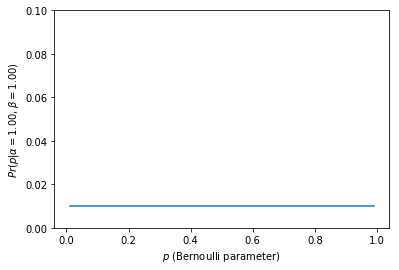

In [121]:
a = 1.
b = 1.

xs = np.arange(0.01, 1., 0.01)
ys = beta_dist.pdf(xs, a, b)
ys /= np.sum(ys)

f, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_ylim([0., 0.1])
ax.set_xlabel(r'$p$ (Bernoulli parameter)')
ax.set_ylabel(r'$Pr(p | \alpha=%.2f, \beta=%.2f)$' % (a, b))
plt.show()

# Run

In [140]:
if 0:
    results = []
    for _ in tqdm(range(50)):

        # model = BetaBinomial(alpha=1., beta=1.)
        # model = BinomialMLE()
        model = BetaPriorMC(alpha=3., beta=3.)
        crp_alpha = 1.

        # c_i = np.random.randint(0, 10)
        # j_i1, j_i2 = np.random.choice(10, replace=False, size=2)
        # print(c_i, j_i1, j_i2)
        c_i = 0
        j_i1, j_i2 = 0, 1

        # D1 = data.values[0, :50].astype(np.int8).reshape(1, -1)
        d_CAR = data[data['Geographic origin'] == 'Central African Republic'].values[c_i, :50].reshape(1, -1).astype(np.int8)
        n_CAR = Leaf(d_CAR, crp_alpha, model)

        # D2 = data.values[1, :50].astype(np.int8).reshape(1, -1)
        d_JPN = data[data['Geographic origin'] == 'Japan'].values[j_i1, :50].reshape(1, -1).astype(np.int8)
        n_JPN = Leaf(d_JPN, crp_alpha, model)

        # D3 = data.values[500, :50].astype(np.int8).reshape(1, -1) 
        d_JPN2 = data[data['Geographic origin'] == 'Japan'].values[j_i2, :50].reshape(1, -1).astype(np.int8)
        n_JPN2 = Leaf(d_JPN2, crp_alpha, model)

        LL_CAR = n_CAR.log_pr_data_tk
        LL_JPN = n_JPN.log_pr_data_tk
        LL_JPN2 = n_JPN2.log_pr_data_tk



        N_JPN = Node.merge(n_JPN, n_JPN2)
        N_MIX = Node.merge(n_JPN, n_CAR)

        results.append((np.exp(N_JPN.log_rk), np.exp(N_MIX.log_rk)))


    results = np.array(results)
    h1, b1 = np.histogram(results[:, 0], bins=np.linspace(0, 1, 10))
    h2, b2 = np.histogram(results[:, 1], bins=np.linspace(0, 1, 10))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    ax1.bar(b1[:-1], h1)
    ax2.bar(b2[:-1], h2)
    ax1.set_title('JPN')
    ax2.set_title('MIX')
    plt.show()
    

if 1:
    # model = BetaBinomial(alpha=1., beta=1.)
    # model = BinomialMLE()
    model = BetaPriorMC(alpha=3., beta=3.)
    crp_alpha = 1.

    # c_i = np.random.randint(0, 10)
    # j_i1, j_i2 = np.random.choice(10, replace=False, size=2)
    # print(c_i, j_i1, j_i2)
    c_i = 0
    j_i1, j_i2 = 0, 1

    # D1 = data.values[0, :50].astype(np.int8).reshape(1, -1)
    d_CAR = data[data['Geographic origin'] == 'Central African Republic'].values[c_i, :50].reshape(1, -1).astype(np.int8)
    n_CAR = Leaf(d_CAR, crp_alpha, model)

    # D2 = data.values[1, :50].astype(np.int8).reshape(1, -1)
    d_JPN = data[data['Geographic origin'] == 'Japan'].values[j_i1, :50].reshape(1, -1).astype(np.int8)
    n_JPN = Leaf(d_JPN, crp_alpha, model)

    # D3 = data.values[500, :50].astype(np.int8).reshape(1, -1) 
    d_JPN2 = data[data['Geographic origin'] == 'Japan'].values[j_i2, :50].reshape(1, -1).astype(np.int8)
    n_JPN2 = Leaf(d_JPN2, crp_alpha, model)

    LL_CAR = n_CAR.log_pr_data_tk
    LL_JPN = n_JPN.log_pr_data_tk
    LL_JPN2 = n_JPN2.log_pr_data_tk



    N_JPN = Node.merge(n_JPN, n_JPN2)
    N_MIX = Node.merge(n_JPN, n_CAR)
    
    # print('P(D_i | H_1^i):', LL_CAR, LL_JPN, LL_JPN2)
    # print('P(D_k | H_1^k):', N_JPN.log_pr_data_h1, N_MIX.log_pr_data_h1)
    # print('P(D_k | T_k):  ', N_JPN.log_pr_data_tk, N_MIX.log_pr_data_tk)
    # print('P(H_1^k | D_k):', np.exp(N_JPN.log_rk), np.exp(N_MIX.log_rk))


    print('JAPAN NODE')
    print('P(D_i | H_1^i):', LL_JPN, LL_JPN2)
    print('P(D_k | H_1^k):', N_JPN.log_pr_data_h1)
    print('P(D_k | T_k):  ', N_JPN.log_pr_data_tk)
    print('P(H_1^k | D_k):', np.exp(N_JPN.log_rk))

    print('')
    print('MIXED NODE')
    print('P(D_i | H_1^i):', LL_JPN, LL_CAR)
    print('P(D_k | H_1^k):', N_MIX.log_pr_data_h1)
    print('P(D_k | T_k):  ', N_MIX.log_pr_data_tk)
    print('P(H_1^k | D_k):', np.exp(N_MIX.log_rk))

JAPAN NODE
P(D_i | H_1^i): -58.13950372635665 -57.252763186108545
P(D_k | H_1^k): -114.88371951935444
P(D_k | T_k):   -115.1060081258152
P(H_1^k | D_k): 0.6244658878173511

MIXED NODE
P(D_i | H_1^i): -58.13950372635665 -56.28910072665252
P(D_k | H_1^k): -115.99577197066323
P(D_k | T_k):   -114.93225976003131
P(H_1^k | D_k): 0.17262055946211347
